# Selección de características

In [48]:
from model import Data

# Uso de SMOTE para balancear el dataset
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier


import pandas as pd

In [49]:
LOCAL_ROUTE: str = "./sample_data/clean_data.csv"


full_dataframe = pd.read_csv(LOCAL_ROUTE)
COLS_NUMERICAS = full_dataframe.iloc[:, 2:-1].columns

X = full_dataframe[COLS_NUMERICAS]
y = full_dataframe[Data.CONTAMINACION_METALICA]

# Crear el balanceo con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos resampleados (conservando las columnas originales)
full_dataframe_resampled = pd.concat(
    [
        full_dataframe.iloc[:, :2],  # Conservar las primeras dos columnas (ej: estación, fecha)
        pd.DataFrame(X_resampled, columns=X.columns),  # Las características resampleadas
        pd.DataFrame(y_resampled, columns=[Data.CONTAMINACION_METALICA])  # La variable objetivo resampleada
    ],
    axis=1
)

# Mostrar la nueva distribución de las clases después de SMOTE
print(full_dataframe_resampled[Data.CONTAMINACION_METALICA].value_counts())

# Guardar el DataFrame resampleado en 'smote_data.csv'
full_dataframe_resampled.to_csv("./sample_data/smote_data.csv", index=False)

contaminacion_metalica
bajo      1159
medio     1159
alto      1159
viable    1159
Name: count, dtype: int64


Correlación de las características con la variable objetivo:
contaminacion_metalica           1.000000
oxigeno_disuelto_mg_o2_l         0.183975
cadmio_total_mg_cd_l             0.028439
cloruros_mg_cl_l                 0.022918
ph                               0.022322
nitritos_mg_n_no2_l              0.010696
nitratos_mg_n_no3_l              0.009880
sulfatos_mg_so4_l                0.006135
coliformes_totales_nmp_100       0.005979
demanda_bioquimica_de_oxigeno   -0.001416
coliformes_fecales_nmp_100      -0.007120
fosforo_total_mg_p_l            -0.016359
fosfatos_mg_po4_l               -0.022222
magnesio_mg_mg_l                -0.077711
zinc_total_mg_zn_l              -0.106550
conductividad_el_ctrica_s       -0.117098
calcio_mg_ca_l                  -0.120779
dureza_magnesica_mg_caco3       -0.138383
manganeso_total_mg_mn_l         -0.173516
niquel_total_mg_ni_l            -0.198853
nitrogeno_total_mg_n_l          -0.218138
temperatura_c                   -0.219129
nitrogeno_amoni

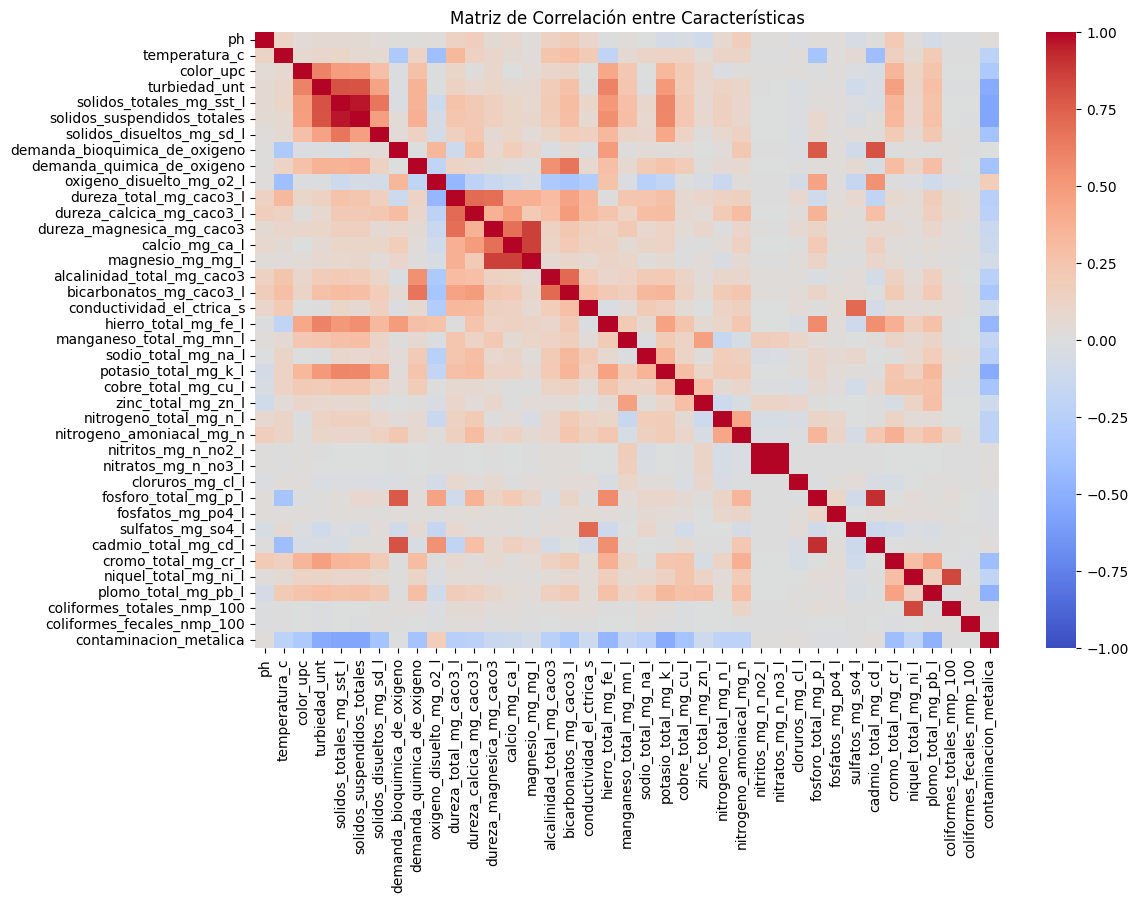

In [50]:
# ** Filtrar solo las columnas numéricas (sin incluir las de texto como estaciones, fechas, etc.) **
TARGET = Data.CONTAMINACION_METALICA

# ** Codificar la columna CONTAMINACION_METALICA en valores numéricos **
label_encoder = LabelEncoder()
full_dataframe_resampled[TARGET] = label_encoder.fit_transform(full_dataframe_resampled[TARGET])

# ** Filtrar solo las columnas numéricas (sin incluir las de texto como estaciones, fechas, etc.) **
df_numeric = full_dataframe_resampled.select_dtypes(include=['float64', 'int64'])

# ** Añadir la columna objetivo codificada al DataFrame numérico **
df_numeric[TARGET] = full_dataframe_resampled[TARGET]

# ** Calcular la matriz de correlación entre todas las variables numéricas **
correlation_matrix = df_numeric.corr()

# ** Mostrar las correlaciones de todas las variables con la variable objetivo (CONTAMINACION_METALICA) **
correlation_with_target = correlation_matrix[TARGET].sort_values(ascending=False)
print("Correlación de las características con la variable objetivo:")
print(correlation_with_target)

# ** Graficar una matriz de calor de las correlaciones (para visualizar relaciones entre variables) **
plt.figure(figsize=(12, 8))  # Ajustamos el tamaño de la figura
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)  # "annot=False" para quitar los números
plt.title('Matriz de Correlación entre Características')
plt.show()


## Aplicación de SMOTE para balancear el conjunto de datos

In [51]:

print("-" * 10, "|>", "-" * 10)
# ** Parte 2: Aplicar SMOTE y guardar los datos resampleados **

# Definir las características (X) y la variable objetivo (y)
X = full_dataframe[COLS_NUMERICAS]
y = full_dataframe[Data.CONTAMINACION_METALICA]

# Crear el balanceo con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos resampleados (conservando las columnas originales)
full_dataframe_resampled = pd.concat(
    [
        full_dataframe.iloc[:, :2],  # Conservar las primeras dos columnas (ej: estación, fecha)
        pd.DataFrame(X_resampled, columns=X.columns),  # Las características resampleadas
        pd.DataFrame(y_resampled, columns=[Data.CONTAMINACION_METALICA])  # La variable objetivo resampleada
    ],
    axis=1
)

# Mostrar la nueva distribución de las clases después de SMOTE
print(full_dataframe_resampled[Data.CONTAMINACION_METALICA].value_counts())

# Guardar el DataFrame resampleado en 'smote_data.csv'
full_dataframe_resampled.to_csv("./sample_data/smote_data.csv", index=False)

---------- |> ----------
contaminacion_metalica
bajo      1159
medio     1159
alto      1159
viable    1159
Name: count, dtype: int64


In [52]:
# ** Seleccionar las características con una correlación mayor a un umbral (positivo o negativo) **
threshold = 0.3  # Umbral de correlación
high_corr_features = correlation_with_target[abs(correlation_with_target) >= threshold].index.tolist()

# Excluir la variable objetivo de la lista (ya que tiene una correlación de 1 consigo misma)
high_corr_features.remove(TARGET)

# Mostrar las características seleccionadas
print("Características con alta correlación (>= 0.3 o <= -0.3):", high_corr_features)

Características con alta correlación (>= 0.3 o <= -0.3): ['color_upc', 'bicarbonatos_mg_caco3_l', 'cobre_total_mg_cu_l', 'demanda_quimica_de_oxigeno', 'solidos_disueltos_mg_sd_l', 'cromo_total_mg_cr_l', 'hierro_total_mg_fe_l', 'plomo_total_mg_pb_l', 'turbiedad_unt', 'potasio_total_mg_k_l', 'solidos_totales_mg_sst_l', 'solidos_suspendidos_totales']


# Árbol de decisión

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split


def train_decision_tree(X, y, param_grid=None, test_size=0.3, random_state=42):
    if param_grid is None:
        param_grid = {"max_depth": range(3, 20)}  # Parámetros por defecto

    # Dividir los datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # GridSearchCV para encontrar la mejor profundidad del árbol
    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=random_state),
        param_grid=param_grid,
        cv=10,  # Validación cruzada de 5 pliegues
        scoring="accuracy",
    )

    # Entrenar el GridSearch para encontrar el mejor modelo
    grid_search.fit(X_train, y_train)

    # Mejor modelo encontrado por GridSearch
    best_clf = grid_search.best_estimator_

    # Hacer predicciones
    y_pred = best_clf.predict(X_test)

    # Evaluar el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del Árbol de Decisión: {accuracy * 100:.2f}%")

    # Matriz de confusión y reporte de clasificación
    print("\nMatriz de Confusión (Árbol de Decisión):")
    print(confusion_matrix(y_test, y_pred))
    print("\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Devolver el mejor modelo entrenado
    return best_clf

# Random Forest

In [54]:
def train_random_forest(X, y, param_grid=None, test_size=0.3, random_state=42):
    if param_grid is None:
        param_grid = {"n_estimators": [100, 200, 300], "max_depth": [10, 14, 18, 22]}

    # Dividir los datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # GridSearchCV para Random Forest
    grid_search_rf = GridSearchCV(
        estimator=RandomForestClassifier(random_state=random_state),
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
    )

    # Entrenar el GridSearch para encontrar el mejor modelo
    grid_search_rf.fit(X_train, y_train)

    # Mejor modelo encontrado por GridSearch
    best_rf_clf = grid_search_rf.best_estimator_

    # Hacer predicciones
    y_pred_rf = best_rf_clf.predict(X_test)

    # Evaluar el rendimiento del modelo
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Precisión del Random Forest: {accuracy_rf * 100:.2f}%")

    # Matriz de confusión y reporte de clasificación
    print("\nMatriz de Confusión (Random Forest):")
    print(confusion_matrix(y_test, y_pred_rf))
    print("\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred_rf))

    # Devolver el mejor modelo entrenado
    return best_rf_clf

# Gradient Boosting

In [55]:
def train_gradient_boosting(X, y, param_grid=None, test_size=0.3, random_state=42):
    if param_grid is None:
        param_grid = {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 4, 5],
        }

    # Dividir los datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # GridSearchCV para Gradient Boosting
    grid_search_gb = GridSearchCV(
        estimator=GradientBoostingClassifier(random_state=random_state),
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
    )

    # Entrenar el GridSearch para encontrar el mejor modelo
    grid_search_gb.fit(X_train, y_train)

    # Mejor modelo encontrado por GridSearch
    best_gb_clf = grid_search_gb.best_estimator_

    # Hacer predicciones
    y_pred_gb = best_gb_clf.predict(X_test)

    # Evaluar el rendimiento del modelo
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    print(f"Precisión del Gradient Boosting: {accuracy_gb * 100:.2f}%")

    # Matriz de confusión y reporte de clasificación
    print("\nMatriz de Confusión (Gradient Boosting):")
    print(confusion_matrix(y_test, y_pred_gb))
    print("\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred_gb))

    # Devolver el mejor modelo entrenado
    return best_gb_clf

# Análisis de modelos

In [56]:
# # Variables de entrada
# FEATURES = high_corr_features  # Las características seleccionadas
# TARGET = Data.CONTAMINACION_METALICA  # Variable objetivo

# # Crear el DataFrame para trabajar
# df = full_dataframe_resampled.copy()
# X = df[FEATURES]
# y = df[TARGET]

# # Codificar las etiquetas de la variable objetivo
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Entrenar y evaluar cada modelo
# dtree_model = train_decision_tree(X, y_encoded)
# rforest_model = train_random_forest(X, y_encoded)
# gb_model = train_gradient_boosting(X, y_encoded)

## Matriz de confusión normalizada

cada celda mostrará la proporción de ejemplos correctamente clasificados y mal clasificados como fracción del total de ejemplos de la clase verdadera. Esto te permitirá ver más fácilmente qué clases están siendo confundidas y qué tan bien está funcionando el modelo para cada una.

In [57]:
def plot_confusion_matrix(
    model, X_test, y_test, label_encoder, title="Matriz de Confusión Normalizada"
):
    # Hacer predicciones con el modelo dado
    y_pred = model.predict(X_test)

    # Crear la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Normalizar la matriz de confusión por cada fila (clase verdadera)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Mostrar la matriz de confusión normalizada
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_normalized, display_labels=label_encoder.classes_
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


## Curva ROC y AUC

La curva ROC (Receiver Operating Characteristic) y el AUC (Area Under the Curve) son herramientas útiles cuando trabajas con problemas de clasificación, como es tu caso. Estas curvas permiten evaluar la capacidad del modelo para distinguir entre las diferentes clases (si hay o no "contaminación metálica").

In [58]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


def plot_roc_auc(model, X_test, y_test, n_classes, title="Curva ROC y AUC"):
    # Obtener las probabilidades de predicción del modelo
    y_score = model.predict_proba(X_test)

    # Binarizar las etiquetas si es multiclase
    y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])

    # Crear una figura para las curvas ROC
    plt.figure()

    # Para cada clase, calcular la curva ROC y el AUC
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Clase {i} (AUC = {roc_auc:.2f})")

    # Línea de referencia para el clasificador aleatorio
    plt.plot([0, 1], [0, 1], "k--", label="Clasificador Aleatorio")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Aprendizaje
Nos permitirá evaluar cómo el rendimiento del modelo cambia a medida que se aumenta el tamaño del conjunto de entrenamiento. Es útil para detectar problemas de sobreajuste (overfitting) o subajuste (underfitting).

- **Sobreajuste:** Si el modelo tiene un rendimiento excelente en el conjunto de entrenamiento pero pobre en el conjunto de validación, puede ser una señal de sobreajuste.
- **Subajuste:** Si tanto el conjunto de entrenamiento como el de validación tienen un bajo rendimiento, puede significar que el modelo es demasiado simple para capturar la complejidad de los datos.
Implementación e

In [59]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(model, X_train, y_train, title="Curva de Aprendizaje"):
    # Generar la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calcular la media y desviación estándar para los conjuntos de entrenamiento y validación
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Graficar la curva de aprendizaje
    plt.figure(figsize=(10, 6))
    plt.plot(
        train_sizes, train_mean, "o-", color="blue", label="Precisión en entrenamiento"
    )
    plt.plot(
        train_sizes, test_mean, "o-", color="green", label="Precisión en validación"
    )

    # Rellenar la desviación estándar
    plt.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="blue",
    )
    plt.fill_between(
        train_sizes,
        test_mean - test_std,
        test_mean + test_std,
        alpha=0.1,
        color="green",
    )

    # Etiquetas y leyenda
    plt.title(title)
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Precisión")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

## Importancia de características

In [60]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_feature_importance(model, FEATURES, title="Importancia de Características"):
    # Obtener la importancia de las características
    importances = model.feature_importances_

    # Crear un DataFrame para visualizar las características y su importancia
    features_df = pd.DataFrame(
        {"Características": FEATURES, "Importancia": importances}
    )

    # Ordenar las características por importancia
    features_df = features_df.sort_values(by="Importancia", ascending=False)

    # Graficar las características más importantes
    plt.figure(figsize=(10, 6))
    plt.barh(
        features_df["Características"], features_df["Importancia"], color="skyblue"
    )
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title(title)
    plt.gca().invert_yaxis()  # Invertir el eje para mostrar las más importantes arriba
    plt.show()

# Evaluación de modelos

In [61]:
def plot_confusion_matrices(models, model_names, X_test, y_test, label_encoder):
    n_models = len(models)
    fig, axes = plt.subplots(
        1, n_models, figsize=(15, 5)
    )  # Crear subplots en una sola fila

    for ax, model, name in zip(axes, models, model_names):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm_normalized, display_labels=label_encoder.classes_
        )
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.set_title(f"Matriz de Confusión - {name}")

    plt.tight_layout()
    plt.show()


def plot_roc_curves(models, model_names, X_test, y_test, n_classes):
    plt.figure(figsize=(10, 6))

    for model, name in zip(models, model_names):
        y_score = model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])

        # Para cada clase, calcular la curva ROC y el AUC
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} - Clase {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Clasificador Aleatorio")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC comparativa")
    plt.legend(loc="lower right")
    plt.show()


def plot_learning_curves(models, model_names, X_train, y_train):
    plt.figure(figsize=(10, 6))

    for model, name in zip(models, model_names):
        train_sizes, train_scores, test_scores = learning_curve(
            model,
            X_train,
            y_train,
            cv=5,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
        )

        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.plot(train_sizes, train_mean, "o-", label=f"{name} - Entrenamiento")
        plt.plot(train_sizes, test_mean, "o--", label=f"{name} - Validación")

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Precisión")
    plt.title("Curva de Aprendizaje comparativa")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


def plot_feature_importances(models, model_names, FEATURES):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(15, 5))

    for ax, model, name in zip(axes, models, model_names):
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            features_df = pd.DataFrame(
                {"Características": FEATURES, "Importancia": importances}
            ).sort_values(by="Importancia", ascending=False)

            ax.barh(
                features_df["Características"],
                features_df["Importancia"],
                color="skyblue",
            )
            ax.set_title(f"Importancia de Características - {name}")
            ax.invert_yaxis()  # Mostrar la más importante arriba

    plt.tight_layout()
    plt.show()

def evaluate_models_comparatively(
    models,
    model_names,
    X_train,
    X_test,
    y_train,
    y_test,
    FEATURES,
    label_encoder,
    n_classes,
):
    print("Evaluando modelos comparativamente...\n")

    # Matriz de Confusión Normalizada comparativa
    plot_confusion_matrices(models, model_names, X_test, y_test, label_encoder)

    # Curva ROC comparativa
    plot_roc_curves(models, model_names, X_test, y_test, n_classes)

    # Curva de Aprendizaje comparativa
    plot_learning_curves(models, model_names, X_train, y_train)

    # Importancia de características comparativa
    plot_feature_importances(models, model_names, FEATURES)


Precisión del Árbol de Decisión: 86.41%

Matriz de Confusión (Árbol de Decisión):
[[344   0  15   0]
 [  0 276  37  43]
 [ 20  46 272   0]
 [  0  28   0 310]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       359
           1       0.79      0.78      0.78       356
           2       0.84      0.80      0.82       338
           3       0.88      0.92      0.90       338

    accuracy                           0.86      1391
   macro avg       0.86      0.86      0.86      1391
weighted avg       0.86      0.86      0.86      1391

Precisión del Random Forest: 92.67%

Matriz de Confusión (Random Forest):
[[351   0   8   0]
 [  0 305  17  34]
 [ 13  23 302   0]
 [  0   7   0 331]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       359
           1       0.91      0.86      0.88       356
           2       0.92      0.89     

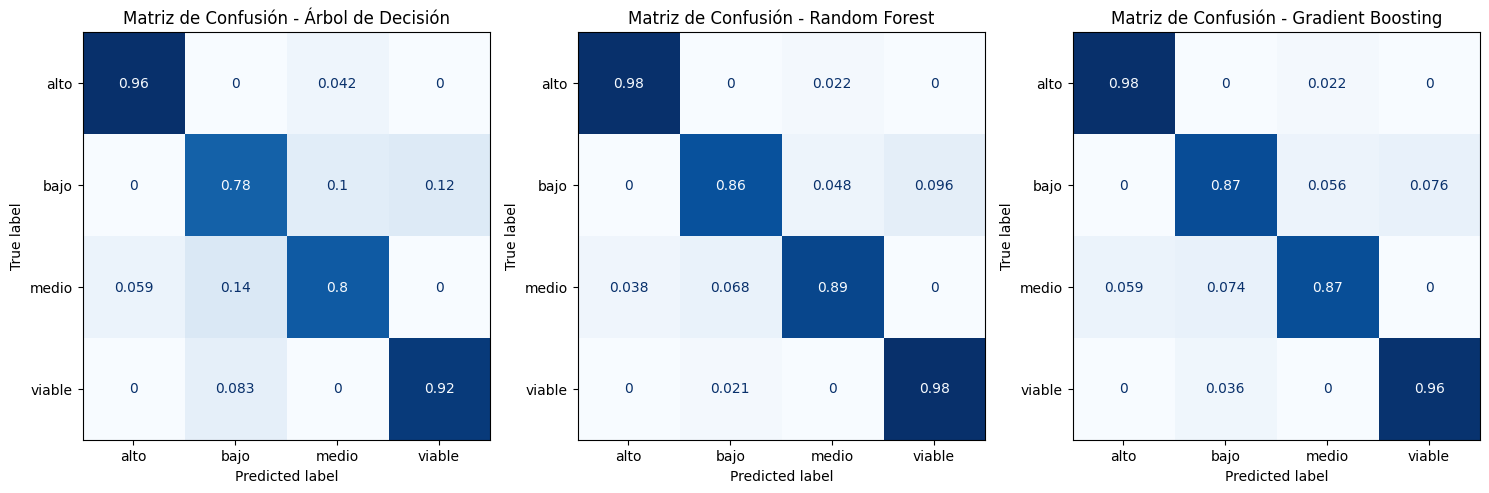

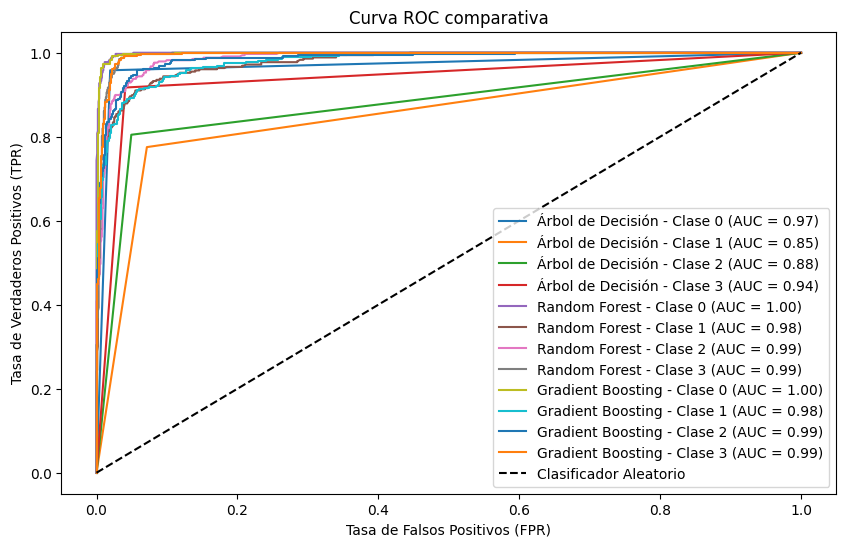

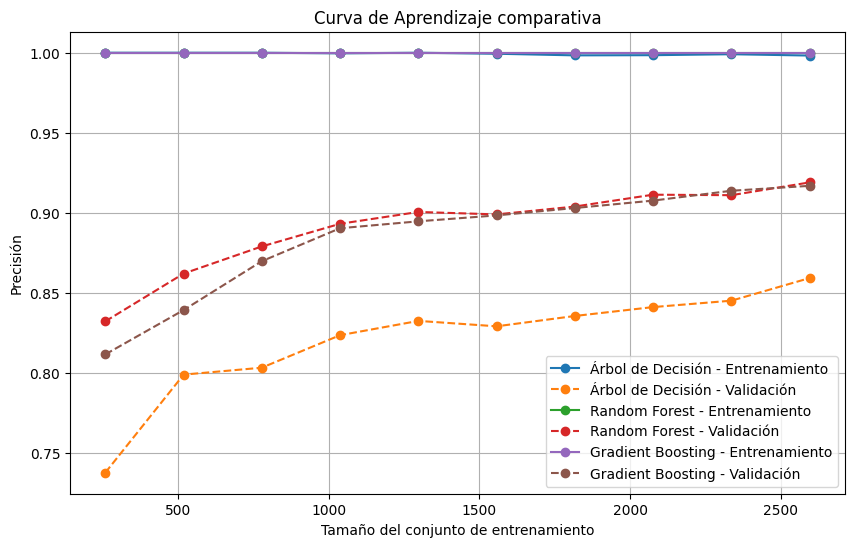

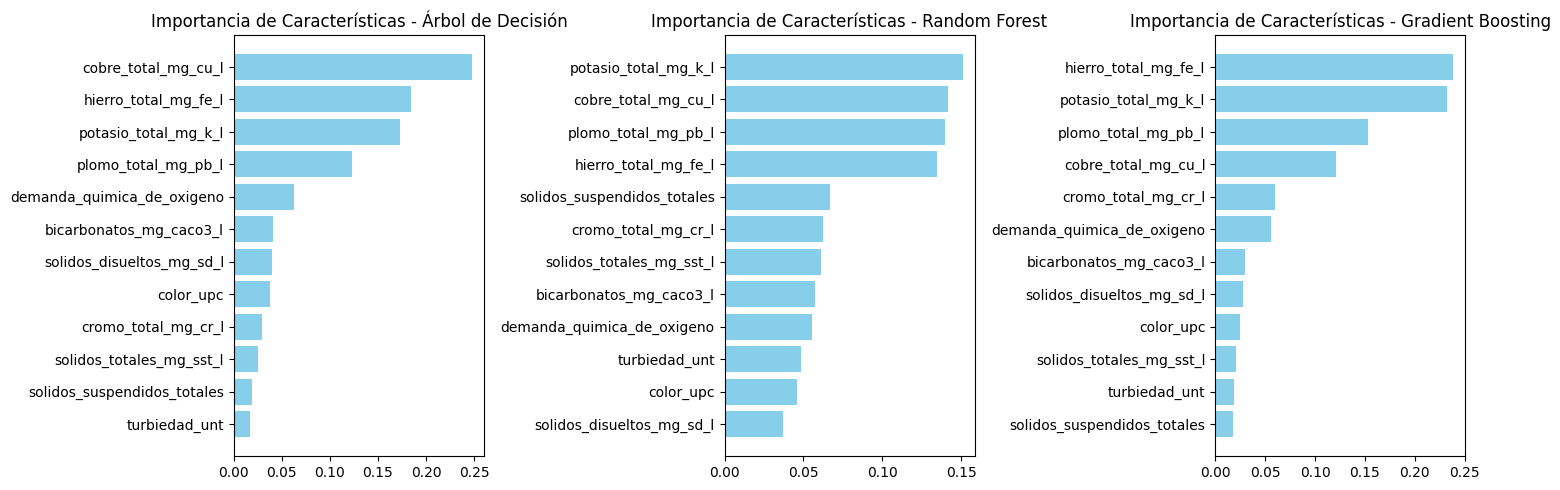

In [62]:
# Variables de entrada
FEATURES = high_corr_features  # Las características seleccionadas
TARGET = Data.CONTAMINACION_METALICA  # Variable objetivo

# Crear el DataFrame para trabajar
df = full_dataframe_resampled.copy()
X = df[FEATURES]
y = df[TARGET]

# Codificar las etiquetas de la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Entrenar y evaluar cada modelo
dtree_model = train_decision_tree(X, y_encoded)
rforest_model = train_random_forest(X, y_encoded)
gb_model = train_gradient_boosting(X, y_encoded)

# Lista de modelos entrenados
models = [dtree_model, rforest_model, gb_model]
model_names = ["Árbol de Decisión", "Random Forest", "Gradient Boosting"]

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Evaluar todos los modelos
evaluate_models_comparatively(models, model_names, X_train, X_test, y_train, y_test, FEATURES, label_encoder, n_classes=len(np.unique(y_train)))